<a href="https://colab.research.google.com/github/leahmashi/DL_HW1/blob/main/DL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Deep learning workshop 1



In [ ]:
# installs
!pip install split-folders
!pip install lightning>=2.0

In [18]:
# imports 
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import datasets
from collections import Counter 
import splitfolders
import lightning as L
import torch.nn.functional as F

## Getting the images from kaggle

In [2]:
# connecting to local file system to upload authorization file (for downloading from kaggle)
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! kaggle datasets download -d lantian773030/pokemonclassification

100% 417M/417M [00:11<00:00, 39.6MB/s]
100% 417M/417M [00:11<00:00, 38.6MB/s]


In [5]:
# ! rm -r /content/PokemonData
!unzip /content/pokemonclassification.zip

Streaming output truncated to the last 5000 lines.
  inflating: PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg  
  inflating: PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg  
  inflating: PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg  
  inflating: PokemonData/G

## Explore the data

### Creating the dataset

In [6]:
splitfolders.ratio('/content/PokemonData', output="output", seed=1337, ratio=(0.8, 0.1, 0.1)) 

train_set = datasets.ImageFolder("/content/output/train", transform=torchvision.transforms.ToTensor())
test_set = datasets.ImageFolder("/content/output/test", transform=torchvision.transforms.ToTensor())
validation_set = datasets.ImageFolder("/content/output/val", transform=torchvision.transforms.ToTensor())
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=torchvision.transforms.ToTensor())

BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)


Copying files: 6837 files [00:01, 4122.11 files/s]


### Extracting metadata from dataset

In [7]:
# size of dataset
len(imagenet_data)

6820

In [8]:
# sample the data
x0, y0 = imagenet_data[0]
print("1st sample: ", x0.shape)

x1, y1 = imagenet_data[1]
print("2nd sample: ", x1.shape)

1st sample:  torch.Size([3, 220, 229])
2nd sample:  torch.Size([3, 422, 422])


from the cell above we can see that the dimensions are different for each picture but there are 3 channels (red, green and blue) \
since the dimensions are different we need to preprocess the images by resizing them:


In [9]:
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
]))
train_set = datasets.ImageFolder("/content/output/train", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
]))
test_set = datasets.ImageFolder("/content/output/test", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
]))
validation_set = datasets.ImageFolder("/content/output/val", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# size of dataset
print("dataset size: ", len(imagenet_data))

# sample the data
x0, y0 = imagenet_data[0]
print("check the pictures are from the same dimensions: ")
print("1st sample: ", x0.shape)

x1, y1 = imagenet_data[1]
print("2nd sample: ", x1.shape)

# number of classes
print("number of classes: ", len(imagenet_data.classes))

# number of examples per class
counts = dict(Counter(imagenet_data.targets))
labels = imagenet_data.class_to_idx
y_dictionary = {label : counts[labels[label]] for label  in labels}
print(y_dictionary)

dataset size:  6820
check the pictures are from the same dimensions: 
1st sample:  torch.Size([3, 256, 256])
2nd sample:  torch.Size([3, 256, 256])
number of classes:  150
{'Abra': 35, 'Aerodactyl': 35, 'Alakazam': 26, 'Alolan Sandslash': 41, 'Arbok': 41, 'Arcanine': 41, 'Articuno': 45, 'Beedrill': 34, 'Bellsprout': 40, 'Blastoise': 42, 'Bulbasaur': 41, 'Butterfree': 27, 'Caterpie': 37, 'Chansey': 43, 'Charizard': 35, 'Charmander': 51, 'Charmeleon': 46, 'Clefable': 38, 'Clefairy': 46, 'Cloyster': 48, 'Cubone': 40, 'Dewgong': 43, 'Diglett': 39, 'Ditto': 40, 'Dodrio': 39, 'Doduo': 35, 'Dragonair': 42, 'Dragonite': 48, 'Dratini': 26, 'Drowzee': 39, 'Dugtrio': 51, 'Eevee': 37, 'Ekans': 35, 'Electabuzz': 41, 'Electrode': 51, 'Exeggcute': 46, 'Exeggutor': 50, 'Farfetchd': 48, 'Fearow': 48, 'Flareon': 45, 'Gastly': 44, 'Gengar': 49, 'Geodude': 35, 'Gloom': 49, 'Golbat': 48, 'Goldeen': 47, 'Golduck': 46, 'Golem': 46, 'Graveler': 39, 'Grimer': 44, 'Growlithe': 44, 'Gyarados': 46, 'Haunter': 48,

we can see from the cell above that the data is unbalanced

In [11]:
X_train = np.array([np.array(train_set[i][0]) for i in range(len(train_set))])
print("X_train: ", X_train.shape)

y_train = np.array([np.array(train_set[i][1]) for i in range(len(train_set))])
print("y_train: ", y_train.shape)

X_train:  (5391, 3, 256, 256)
y_train:  (5391,)


In [12]:
X_test = np.array([np.array(test_set[i][0]) for i in range(len(test_set))])
print("X_test: ", X_test.shape)

y_test = np.array([np.array(test_set[i][1]) for i in range(len(test_set))])
print("y_test: ", y_test.shape)

X_test:  (814, 3, 256, 256)
y_test:  (814,)


In [13]:
X_valid = np.array([np.array(validation_set[i][0]) for i in range(len(validation_set))])
print("X_valid: ", X_valid.shape)

y_valid = np.array([np.array(validation_set[i][1]) for i in range(len(validation_set))])
print("y_valid: ", y_valid.shape)

X_valid:  (615, 3, 256, 256)
y_valid:  (615,)


our data consists of 5391 training samples, 814 test samples and 615 validation samples

### Augmentation?

### Benchmark results?

### Samples of each label

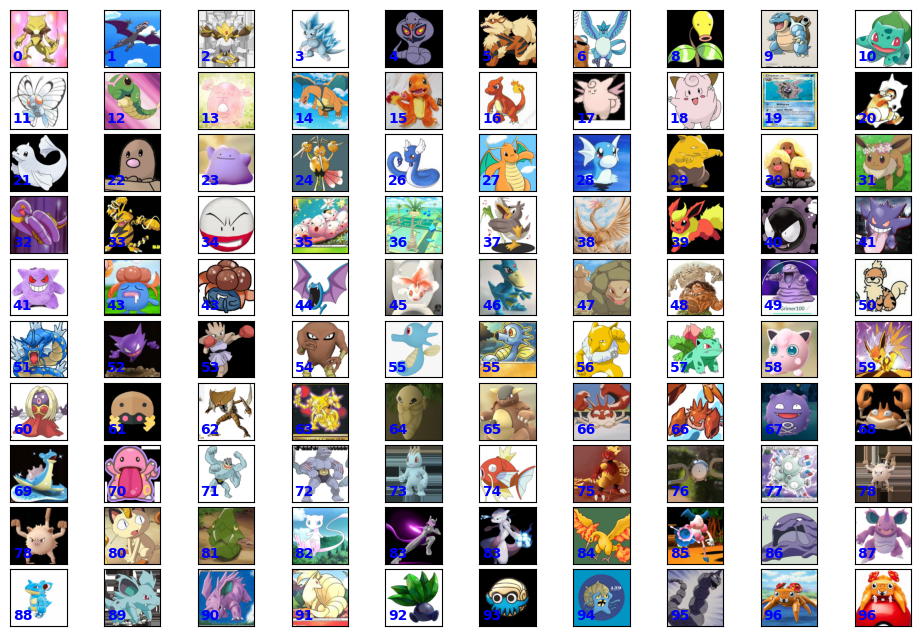

In [14]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i].swapaxes(0,1).swapaxes(1,2).squeeze(),cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        skip += 33
    plt.show()
plot_multiple_imgs(X_train,y_train,10,10,(12,8))

we can see it's hard to differenciate between:  
*   15 and 16
*   22 and 30
*   66 and 68
*   0 and 2 and 63
*   71 and 72 and 73
*   85 and 87






## KFold cross validation

In [40]:
class PokemonMLP(L.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        # define the relevant layers we are about to use
        self.linear_stack = nn.Sequential(
            nn.Linear(256*256*3,6000),
            nn.ReLU(),
            nn.Linear(6000,400),
            nn.ReLU(),
            nn.Linear(400,150)
        )
    
    def forward(self,x):
        return torch.relu(self.linear_stack(x.view(x.size(0),-1)))
    
    def training_step(self, batch, batch_nb):
        X, y = batch
        loss = F.cross_entropy(self(X),y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=1e-2)

pokemon_model = PokemonMLP()
trainer = L.Trainer(
    accelerator='auto',
    devices=1,
    max_epochs=5
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [41]:
trainer.fit(pokemon_model, train_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | linear_stack | Sequential | 19.7 M
--------------------------------------------
19.7 M    Trainable params
0         Non-trainable params
19.7 M    Total params
78.694    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | linear_stack | Sequential | 19.7 M
--------------------------------------------
19.7 M    Trainable params
0         Non-trainable params
19.7 M    Total params
78.694    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [42]:
trainer.test()

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


MisconfigurationException: ignored